# Analysis Crime Vulnerable Area of Gwangjin-gu
- We have cctv, police office, gwangjin-gu area data

## Import Modules

In [3]:
from fiona import collection
from fiona.crs import from_epsg
#from shapely.geometry import Point, mapping
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

OSError: Could not find lib geos_c.dll or load any of its variants ['C:\\ProgramData\\Anaconda3\\Library\\lib\\geos_c.dll'].

In [2]:
crime = pd.read_excel('crime.xlsx') # Load crime data
crime

name  occur  arrest
0       Mapo   5740    3136
1  Seongdong   3582    2048
2    Dongjak   3869    2312
3   Gwangjin   6268    3531
4      Seobu   2400    1498
5    Gangbuk   4030    2806

Text(0.5,1,'Crime Rate')

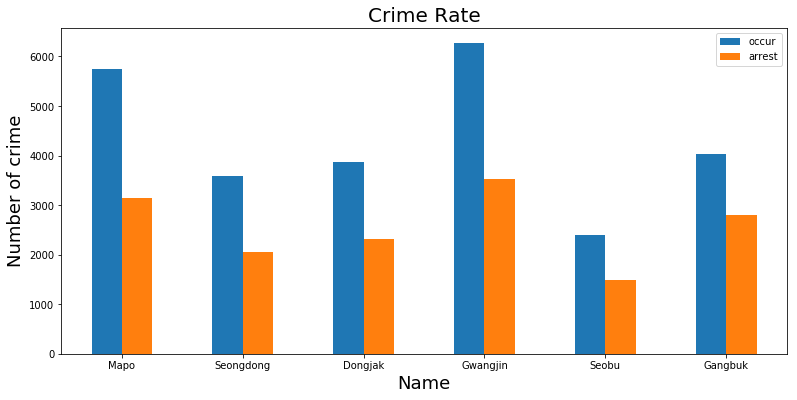

In [3]:
# Plotting the rate of each city
crime.set_index('name', inplace=True) # Convert index with column('name') to make xaxis

plt.figure()
crime.plot(kind='bar', figsize=(13,6))
plt.xlabel("Name",fontsize=18)
plt.xticks(rotation=0) # rotate xaxis list to 0
plt.ylabel("Number of crime",fontsize=18)
plt.title("Crime Rate", fontsize = 20)

## Make Gwangjin-gu polygon

In [4]:
gwangjin_gu =gpd.read_file('seoul/boundary_sigungu.shp') # Load shapefile
gwangjin_gu.head()

SIG_CD SIG_KOR_NM    SIG_ENG_NM  \
0  11590        동작구    Dongjak-gu   
1  11200        성동구  Seongdong-gu   
2  11380        은평구  Eunpyeong-gu   
3  11545        금천구  Geumcheon-gu   
4  11140         중구       Jung-gu   

                                            geometry  
0  POLYGON ((195995.9191341199 446284.5008902991,...  
1  POLYGON ((203835.0973663929 452533.5441002747,...  
2  POLYGON ((195739.4845255773 461696.1931834942,...  
3  POLYGON ((188905.4065269141 442887.4150214592,...  
4  POLYGON ((202043.8946638209 452491.1404552867,...

In [5]:
gwangjin_gu = gwangjin_gu[gwangjin_gu["SIG_KOR_NM"] == "광진구"] # Filtering the row which column['Sig_KOR_NM'] is '광진구'
gwangjin_gu

SIG_CD SIG_KOR_NM   SIG_ENG_NM  \
16  11215        광진구  Gwangjin-gu   

                                             geometry  
16  POLYGON ((208981.0553260083 452544.5654496419,...

In [6]:
gwangjin_gu.reset_index(drop = True, inplace = True) # To make index clean (16 -> 0)
gwangjin_gu

SIG_CD SIG_KOR_NM   SIG_ENG_NM  \
0  11215        광진구  Gwangjin-gu   

                                            geometry  
0  POLYGON ((208981.0553260083 452544.5654496419,...

In [7]:
gwangjin_gu = gwangjin_gu.drop('SIG_CD', axis = 1) # Drop column['SIG_CD']
gwangjin_gu = gwangjin_gu.drop('SIG_KOR_NM', axis = 1) # Drop column['SIG_KOR_NM']
gwangjin_gu

SIG_ENG_NM                                           geometry
0  Gwangjin-gu  POLYGON ((208981.0553260083 452544.5654496419,...

## Generate Shapefile from CSV(coordinate)
- gwagnjin_gu_cctv

In [8]:
CSVin  = os.path.join('csv_file/gwangjin_gu_cctv.csv') # CSV file directory
shpOut = os.path.join('shp_file/gwangjin_gu_cctv') # Generated Shapefile directory
lng = 'x' # Longitude
lat = 'y' # Latitude
schema = { 'geometry': 'Point', 'properties': { 'name': 'str' } }# The name of Each coordinate
data = pd.read_csv(CSVin)

with collection(shpOut, "w", "ESRI Shapefile", schema) as output:
    for index, row in data.iterrows():
        point = Point(row[lng], row[lat])
        output.write({
            'properties': {'name': row['name']},# The Name of Each coordinate
            'geometry': mapping(point)})

## Current state of Gwangjin-gu CCTV

In [9]:
gwangjin_gu_cctv = gpd.read_file('shp_file/gwangjin_gu_cctv/gwangjin_gu_cctv.shp')
gwangjin_gu_cctv.head()

name                        geometry
0    0   POINT (127.0874122 37.544441)
1    1  POINT (127.0882001 37.5422044)
2    2  POINT (127.0891814 37.5473266)
3    3  POINT (127.0721136 37.5552104)
4    4  POINT (127.0799487 37.5562644)

In [10]:
gwangjin_gu_cctv = gwangjin_gu_cctv.drop('name', axis = 1)
gwangjin_gu_cctv.head()

geometry
0   POINT (127.0874122 37.544441)
1  POINT (127.0882001 37.5422044)
2  POINT (127.0891814 37.5473266)
3  POINT (127.0721136 37.5552104)
4  POINT (127.0799487 37.5562644)

In [11]:
print('cctv coordinate system : ', gwangjin_gu_cctv.crs) # To check the coordinate of it
print('gwangjin_gu coordinate system : ', gwangjin_gu.crs) # To check the coordinate of it

cctv coordinate system :  {}
gwangjin_gu coordinate system :  {'proj': 'tmerc', 'lat_0': 38, 'lon_0': 127, 'k': 1, 'x_0': 200000, 'y_0': 500000, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True}


In [12]:
gwangjin_gu_cctv = gwangjin_gu_cctv.set_geometry("geometry", crs={"init":"epsg:4326"}) # Set Coordinate to 4326
gwagnjin_gu = gwangjin_gu.set_geometry("geometry", crs={"init":"epsg:4326"}) # Set Coordinate to 4326

## Visualization of Gwangjin-gu, CCTV

In [13]:
import folium # The package that help to visual the shapefile
map1 = folium.Map([37.54, 127.09], zoom_start = 14) # Make a map
folium.GeoJson(gwangjin_gu_cctv).add_to(map1) # Add Shapefile to map, shapefile should be converted to GeoJson before adding
folium.GeoJson(gwangjin_gu).add_to(map1)
map1

## Generate Shapefile from CSV(Gwanjin-gu police office)

In [14]:
inCSV  = os.path.join('csv_file/gwangjin_gu_police.csv')##csv파일 이름
shpOut = os.path.join('shp_file/gwangjin_gu_police')##생성하는 shp파일 이름
lng = 'x'##x좌표-경도(x)
lat = 'y'##y좌표-위도(y)
schema = { 'geometry': 'Point', 'properties': { 'name': 'str' } }##각 좌표의 이름

df = pd.read_csv(inCSV) 

data = df
with collection(shpOut, "w", "ESRI Shapefile", schema) as output:
    for index, row in data.iterrows():
        point = Point(row[lng], row[lat])
        output.write({
            'properties': {'name': row['name']},##각 좌표의 이름
            'geometry': mapping(point)
        })

In [15]:
gwangjin_gu_police = gpd.read_file('shp_file/gwangjin_gu_police/gwangjin_gu_police.shp')
gwangjin_gu_police.head()

name                      geometry
0    1  POINT (127.083789 37.542916)
1    2  POINT (127.076839 37.536581)
2    3  POINT (127.103227 37.544412)
3    4  POINT (127.071328 37.546575)
4    5  POINT (127.081438 37.560232)

In [16]:
gwangjin_gu_police.drop('name', axis = 1, inplace = True)
gwangjin_gu_police.head()

geometry
0  POINT (127.083789 37.542916)
1  POINT (127.076839 37.536581)
2  POINT (127.103227 37.544412)
3  POINT (127.071328 37.546575)
4  POINT (127.081438 37.560232)

In [17]:
gwangjin_gu_police.crs

{}

In [18]:
gwangjin_gu_police = gwangjin_gu_police.set_geometry("geometry", crs={"init":"epsg:4326"})
gwangjin_gu_police.crs

{'init': 'epsg:4326'}

## Visualization Gwangjin-gu police office

In [19]:
import folium
map2 = folium.Map([37.54, 127.09], zoom_start = 14)
folium.GeoJson(gwangjin_gu_police).add_to(map2)
folium.GeoJson(gwangjin_gu).add_to(map2)
map2

## Jurisdiction of Gwangjin-gu police office

In [20]:
gwangjin_gu_police.to_crs(epsg=5179, inplace = True) # Set coordinate to 5179
gwangjin_gu_police.head()

geometry
0  POINT (963232.0602161096 1949368.931278013)
1  POINT (962614.9338024998 1948668.840370218)
2  POINT (964949.9143031425 1949527.480099923)
3  POINT (962133.1052342874 1949779.822204977)
4  POINT (963032.9264076133 1951290.966142748)

In [21]:
gwangjin_gu_police_buffer = gwangjin_gu_police.buffer(1000) # Aplly buffer to make range of circle
gwangjin_gu_police_buffer.head()

0    POLYGON ((964232.0602161096 1949368.931278013,...
1    POLYGON ((963614.9338024998 1948668.840370218,...
2    POLYGON ((965949.9143031425 1949527.480099923,...
3    POLYGON ((963133.1052342874 1949779.822204977,...
4    POLYGON ((964032.9264076133 1951290.966142748,...
dtype: object

In [22]:
gwangjin_gu_police_buffer = gpd.GeoDataFrame(gwangjin_gu_police_buffer) # Convert GeodataSeries to GeoDataFrame
gwangjin_gu_police_buffer.head()

0
0  POLYGON ((964232.0602161096 1949368.931278013,...
1  POLYGON ((963614.9338024998 1948668.840370218,...
2  POLYGON ((965949.9143031425 1949527.480099923,...
3  POLYGON ((963133.1052342874 1949779.822204977,...
4  POLYGON ((964032.9264076133 1951290.966142748,...

In [23]:
gwangjin_gu_police_buffer.rename(columns={0:'geometry'}, inplace = True) # Rename column[0] to column[geometry]
gwangjin_gu_police_buffer = gwangjin_gu_police_buffer.set_geometry("geometry", crs={"init":"epsg:5179"}) # Set coordinate to 5179
print('gwangjin_gu_police_buffer coordinate : ',gwangjin_gu_police_buffer.crs) # Checking coordinate
gwangjin_gu_police_buffer.head()

gwangjin_gu_police_buffer coordinate :  {'init': 'epsg:5179'}


geometry
0  POLYGON ((964232.0602161096 1949368.931278013,...
1  POLYGON ((963614.9338024998 1948668.840370218,...
2  POLYGON ((965949.9143031425 1949527.480099923,...
3  POLYGON ((963133.1052342874 1949779.822204977,...
4  POLYGON ((964032.9264076133 1951290.966142748,...

In [24]:
gwangjin_gu_police_buffer.to_crs(epsg=4326, inplace = True)
gwangjin_gu_police_buffer.head()

geometry
0  POLYGON ((127.0951086809533 37.54295535593422,...
1  POLYGON ((127.088157713402 37.53662101648956, ...
2  POLYGON ((127.1145469339433 37.54444949386465,...
3  POLYGON ((127.08264821635 37.54661555375888, 1...
4  POLYGON ((127.092760296796 37.56027159662195, ...

## Visualization jurisdiction

In [25]:
import folium
map3 = folium.Map([37.54, 127.09], zoom_start = 13)
folium.GeoJson(gwangjin_gu_police_buffer).add_to(map3)
folium.GeoJson(gwangjin_gu_police).add_to(map3)
folium.GeoJson(gwangjin_gu).add_to(map3)
map3

## Customize icon of police office
- Change the shape and color of icons

In [26]:
gwangjin_gu_police_red = pd.read_csv('csv_file/gwangjin_gu_police.csv')
import numpy as np
gwangjin_gu_police_red = np.array(gwangjin_gu_police_red)
x = gwangjin_gu_police_red[:,1]
y = gwangjin_gu_police_red[:,2]
count = 0
a = 0
b = 0
import folium
map3 = folium.Map([37.54, 127.09], zoom_start = 13)
folium.GeoJson(gwangjin_gu).add_to(map3)
folium.GeoJson(gwangjin_gu_police_buffer).add_to(map3) ###############color변경 요함...
while True:
    folium.Marker([y[a], x[b]], icon = folium.Icon(color = 'red', icon = 'star')).add_to(map3)
    a+= 1
    b+= 1
    count+= 1
    if count == 12:
        break
map3

## Non-jurisdiction area

In [27]:
gwangjin_gu_police_buffer.head()

geometry
0  POLYGON ((127.0951086809533 37.54295535593422,...
1  POLYGON ((127.088157713402 37.53662101648956, ...
2  POLYGON ((127.1145469339433 37.54444949386465,...
3  POLYGON ((127.08264821635 37.54661555375888, 1...
4  POLYGON ((127.092760296796 37.56027159662195, ...

In [28]:
gwangjin_gu.to_crs(epsg=4326, inplace = True)
gwangjin_gu

SIG_ENG_NM                                           geometry
0  Gwangjin-gu  POLYGON ((127.101664641658 37.57240065395021, ...

In [29]:
# Different
non_jur = gwangjin_gu.geometry.difference(gwangjin_gu_police_buffer.geometry.iloc[0])
i = 1

while True:
    b = non_jur.geometry.difference(gwangjin_gu_police_buffer.geometry.iloc[i])
    non_jur = b
    i = i + 1
    if i ==11:
        break

In [30]:
non_jur = gpd.GeoDataFrame(non_jur)
non_jur.rename(columns = {0:'geometry'}, inplace = True)
non_jur = non_jur.set_geometry("geometry", crs = {"init":"epsg:4326"})

In [31]:
map4 = folium.Map([37.54, 127.09], zoom_start = 13)
folium.GeoJson(non_jur).add_to(map4)
map4

## Result

In [32]:
map5 = folium.Map([37.54, 127.09], zoom_start = 13)
folium.GeoJson(non_jur).add_to(map5)
folium.GeoJson(gwangjin_gu_cctv).add_to(map5)
map5